<a href="https://colab.research.google.com/github/andrea-gasparini/machine-learning-homeworks/blob/master/homework2/homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning - Homework 2

## Libraries import

In [4]:
import numpy as np
import tensorflow as tf
import keras
import os
import sys

from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import image, pyplot as plt
from sklearn.model_selection import train_test_split

## Load data

To run this notebook on Google Colab it's necessary to zip the dataset folder as `dataset.zip` and place it in the root of Google Drive, or set the `colab_dataset_dir` variable with the right path to it.

In [5]:
colab_dataset_dir = "/content/gdrive/MyDrive/dataset.zip"

if 'google.colab' in sys.modules:    
    from google.colab import drive

    drive.mount("/content/gdrive")

    assert os.path.isfile(colab_dataset_dir), "dataset zip file not found in " + colab_dataset_dir

    !cp {colab_dataset_dir} "/content/"
    !unzip -uq "/content/dataset.zip"

    !pip install split-folders  

Mounted at /content/gdrive


### Split the dataset in training and validation sets

In [6]:
import splitfolders

dataset_dir = "./dataset/"
splitted_dataset_dir = "./splitted_dataset/"

splitfolders.ratio(dataset_dir, output=splitted_dataset_dir, seed=42, ratio=(.7, .3), group_prefix=None)

train_dir = splitted_dataset_dir + "train/"
val_dir = splitted_dataset_dir + "val/"

Copying files: 8221 files [00:01, 7187.45 files/s]


### Define ImageDataGenerators for both sets

In [7]:
batch_size = 32
img_height = img_width = 250
color_mode = "rgb"

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

val_datagen = ImageDataGenerator(rescale=1. / 255)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

class_names = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %class_names)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d validation samples from %d classes.' %(val_generator.n,val_generator.num_classes))

Found 5750 images belonging to 8 classes.
Found 2471 images belonging to 8 classes.
Image input (250, 250, 3)
Classes: ['Breadsticks', 'Cereals_box', 'Cocoa_drink_bottle', 'Nitrile_Gloves', 'Pears', 'accent_plate', 'paper_bag', 'plastic_fork']
Loaded 5750 training samples from 8 classes.
Loaded 2471 validation samples from 8 classes.


## Show 10 images from the dataset

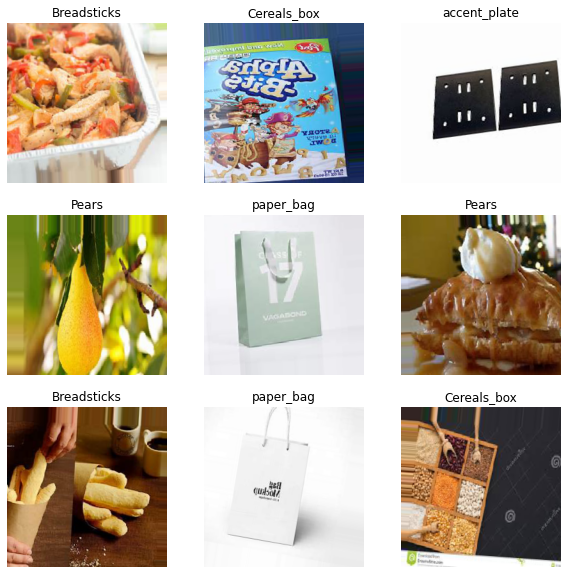

In [8]:
plt.figure(figsize=(10, 10))

images, labels = train_generator.next()

for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i])
  plt.title(class_names[labels[i].argmax()])
  plt.axis("off")

## Create the model

In [9]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    Conv2D(16, 3, input_shape=input_shape, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0

### Train

In [ ]:
train_generator.reset()
steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps = val_generator.n // val_generator.batch_size + 1
epochs = 10

history = model.fit(train_generator, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=val_steps)

Epoch 1/10
151/179 [========================>.....] - ETA: 12s - loss: 2.1055 - accuracy: 0.2802

## Evaluate the model

In [ ]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps = val_generator.n // val_generator.batch_size + 1

preds = model.predict(val_generator, verbose=1, steps=val_steps)

Y_pred = np.argmax(preds, axis=1)
Y_val = val_generator.classes  # shuffle=False in val_generator

print(classification_report(Y_val, Y_pred, labels=None, target_names=class_names, digits=3))

### Plot results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()